In [1]:
import glob

from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['funniness_average'] = 0
test_df['funniness_average'].iloc[0] = 0.1
test_df['funniness_average'].iloc[1] = 1.2
test_df['funniness_average'].iloc[2] = 3.4
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='funniness_average')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_regr_0609_fld*.pth')]
len(model_wt_fnames)

15

In [5]:
!grep Reg ./prod/out_regr_1.txt > ./by_seed_reg_perf

In [6]:
!head by_seed_reg_perf

Reg Fold: 0 RndSeed: 94307,0.545320987701416
Reg Fold: 1 RndSeed: 94307,0.5466374158859253
Reg Fold: 2 RndSeed: 94307,0.5051336288452148
Reg Fold: 3 RndSeed: 94307,0.5269307494163513
Reg Fold: 4 RndSeed: 94307,0.5535845756530762
Reg Fold: 0 RndSeed: 707709,0.5520724058151245
Reg Fold: 1 RndSeed: 707709,0.5270246863365173
Reg Fold: 2 RndSeed: 707709,0.5230923891067505
Reg Fold: 3 RndSeed: 707709,0.5327981114387512
Reg Fold: 4 RndSeed: 707709,0.544309139251709


In [7]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_reg_perf', names = ['id','mse'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,mse,rnd_seed,nfold
0,Reg Fold: 0 RndSeed: 94307,0.545321,94307,0
1,Reg Fold: 1 RndSeed: 94307,0.546637,94307,1
2,Reg Fold: 2 RndSeed: 94307,0.505134,94307,2
3,Reg Fold: 3 RndSeed: 94307,0.526931,94307,3
4,Reg Fold: 4 RndSeed: 94307,0.553585,94307,4


Text(0.5, 1.0, 'Freq of mse over all Random Seeds (20) \n Vert line = min MSE')

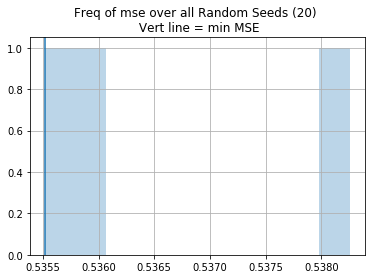

In [8]:
valid_perf.groupby('rnd_seed')['mse'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.groupby('rnd_seed')['mse'].mean().min())

plt.title('Freq of mse over all Random Seeds (20) \n Vert line = min MSE')

In [9]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['mse'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1<=seed_grouped_F1.min()].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_regr_0609_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_regr_0609_fld0_94307.pth',
 'haha_regr_0609_fld1_94307.pth',
 'haha_regr_0609_fld2_94307.pth',
 'haha_regr_0609_fld3_94307.pth',
 'haha_regr_0609_fld4_94307.pth']

In [10]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [11]:
np.array(ensemble_preds).shape

(5, 6000, 1)

In [12]:
out_df = pd.read_csv('sub0610_finetune_bestSeed.csv')
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [13]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
out_df.shape, ens_mean.shape

((6000, 3), (6000, 1))

In [14]:
out_df.funniness_average = ens_mean
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,1.494466
1,tweet2,0,0.082346
2,tweet3,1,2.500741
3,tweet4,0,0.155416
4,tweet5,0,-0.258525


In [15]:
out_df.to_csv('sub0610_finetune_bestSeed.csv',header=True,index=False)

In [16]:
!zip  sub0610_finetune_bestSeed.zip sub0610_finetune_bestSeed.csv 

  adding: sub0610_finetune_bestSeed.csv (deflated 66%)
